In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [3]:
training_data.groupby('call').size()

call
a    13745
f     1600
g     3946
s    17781
dtype: int64

In [4]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [5]:
X.shape

(37072, 67)

In [6]:
Y.shape

(37072, 4)

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [8]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=67, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [10]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [11]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

Epoch 1/10
33364/33364 [==============================] - 18s - loss: 0.8710 - acc: 0.6177    
Epoch 2/10
33364/33364 [==============================] - 18s - loss: 0.7603 - acc: 0.7050    
Epoch 3/10
33364/33364 [==============================] - 19s - loss: 0.7329 - acc: 0.7132    
Epoch 4/10
33364/33364 [==============================] - 19s - loss: 0.7192 - acc: 0.7176    
Epoch 5/10
33364/33364 [==============================] - 19s - loss: 0.7112 - acc: 0.7197    
Epoch 6/10
33364/33364 [==============================] - 19s - loss: 0.7055 - acc: 0.7209    
Epoch 7/10
33364/33364 [==============================] - 19s - loss: 0.7015 - acc: 0.7220    
Epoch 8/10
33364/33364 [==============================] - 19s - loss: 0.6981 - acc: 0.7233    
Epoch 9/10
33364/33364 [==============================] - 19s - loss: 0.6951 - acc: 0.7242    
Epoch 10/10
33364/33364 [==============================] - 21s - loss: 0.8741 - acc: 0.6205    
Epoch 2/10
33364/33364 [=========================

33365/33365 [==============================] - 17s - loss: 0.7623 - acc: 0.7034    
Epoch 3/10
33365/33365 [==============================] - 18s - loss: 0.7348 - acc: 0.7135    
Epoch 4/10
33365/33365 [==============================] - 16s - loss: 0.7214 - acc: 0.7180    
Epoch 5/10
33365/33365 [==============================] - 17s - loss: 0.7131 - acc: 0.7196    
Epoch 6/10
33365/33365 [==============================] - 18s - loss: 0.7076 - acc: 0.7212    
Epoch 7/10
33365/33365 [==============================] - 17s - loss: 0.7032 - acc: 0.7217    
Epoch 8/10
33365/33365 [==============================] - 20s - loss: 0.7002 - acc: 0.7206    
Epoch 9/10
33365/33365 [==============================] - 21s - loss: 0.6968 - acc: 0.7237    
Epoch 10/10
33365/33365 [==============================] - 22s - loss: 0.8741 - acc: 0.6218    
Epoch 2/10
33365/33365 [==============================] - 17s - loss: 0.7633 - acc: 0.7047    
Epoch 3/10
33365/33365 [==============================] - 17

In [12]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [13]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [14]:
metrics.accuracy_score(Y, predicted_transformed)

0.72156883901596891

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [15]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.68      0.73      0.70     13745
          1       0.47      0.13      0.21      1600
          2       0.60      0.51      0.55      3946
          3       0.78      0.81      0.80     17781

avg / total       0.71      0.72      0.71     37072



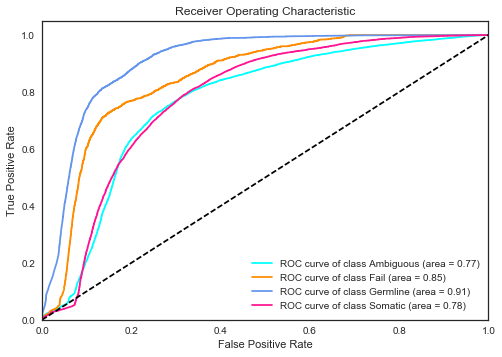

In [17]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [143]:
%matplotlib inline

In [144]:
prob_df = pd.DataFrame(probabilities, columns=['Ambiguous','Fail',
                                               'Germline', 'Somatic'])

# Normalize the values by dividing each value by the sum of its columns
prob_df_norm = prob_df.div(prob_df.sum(axis=1), axis=0)

positive_index = pd.DataFrame(predicted_transformed, columns=['Ambiguous',
                                                              'Fail',
                                                              'Germline', 
                                                              'Somatic'], 
                              dtype=bool)

positive_probabilities = prob_df_norm[positive_index].unstack().dropna().values

positive_counts, bins = np.histogram(positive_probabilities, bins=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

negative_probabilities = prob_df_norm[~positive_index].unstack().dropna()

negative_counts, _ = np.histogram(negative_probabilities, bins=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1])

pct_positive = positive_counts / (positive_counts + negative_counts)

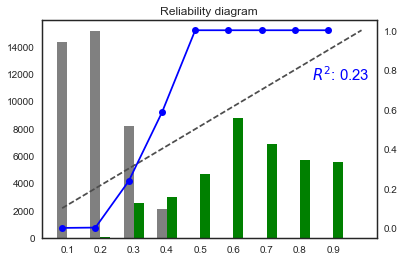

In [145]:
width = 0.03       # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(bins[:-1], negative_counts, width, color='grey')

rects2 = ax1.bar(bins[:-1] + width, positive_counts, width, color='green')

# add some text for labels, title and axes ticks

ax1.set_title('Reliability diagram')
ax1.set_xticks(bins[:-1] + width / 2)
ax1.set_xticklabels(bins[:-1])
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

# ax1.legend((rects1[0], rects2[0]), ('Neg', 'Pos'), loc=5)

ax2 = ax1.twinx()
ax2.plot(bins, bins, ls="--", c=".3")
r2 = str(round(metrics.r2_score(bins[1:], pct_positive),2))
ax2.plot(bins[:-1], pct_positive, "-o", color='blue')
ax2.text(.85,.75,'$R^2$: {0}'.format(r2), color='blue', fontsize=15)


plt.show()